Basic sequencing
================

.. Note::
        A version of this tutorial suitable for RF modules can be found [here](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/tutorials/q1asm_tutorials/basic/rf/basic_sequencing.html).

In this tutorial we will demonstrate basic sequencer based operations (see [Sequencer Operation](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#operation)) for programming a qblox instrument. 
This includes creating a sequence consisting of waveforms and a simple Q1ASM program,
and executing this sequence synchronously on multiple sequencers.

The general process for setting up and executing a program on a Q1 sequencer is as follows:

1. Connect to instrument
2. Prepare a sequence (JSON formatted file) which consists of 
    - Waveforms for playback
    - Weights for weighted integration
    - Acquisitions for capture
    - Q1ASM program to be executed by the sequencer
3. This sequence is then loaded onto a sequencer on the connected instrument using the method `instrument_variable.sequencerX.sequence("SequenceFile.json")`
4. The sequencer is then setup over its API as necessary 
5. Sequencer is then armed and started to commence the experiment
6. Stop the sequencer and close down all instruments

This tutorial will give a basic introduction on how to work with the waveforms and Q1ASM segments of a sequence.

In the Tutorial the sequence is going to consecutively play two waveforms, a gaussian and block with a duration of 20ns each, with an increasing wait period
in between them. We will increase the wait period by 20ns repeated 100 times, after which the sequence is stopped. The sequence will also trigger marker
output 1 at every interval, so that the sequence can be easily monitored on an oscilloscope.

We can perform this tutorial with either a Cluster QCM/QRM . We use the term 'QxM' encompassing both QCM and QRM modules.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive
from qcodes import Instrument
from qblox_instruments import Cluster, PlugAndPlay

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [2]:
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()

# Scan for available devices and display
names = {dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()}
ip_addresses = {dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[
        (names[dev_id] + " @" + ip_addresses[dev_id], dev_id) for dev_id in device_list.keys()
    ],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('Marketing-Cluster @192.168.1.170', '00015_2247_002'),), value…

### Connect to Cluster

We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use. Note that you need to set `select_qrm_type` to `False` is you are using a qcm.

In [3]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.

# PlugAndPlay assigns an instrument name with a hyphen. For example 'pulsar-qrm' as a string for instrument name.
# QCodes instrument class cannot handle hyphens, and changes them to underscore '_'.
# However, this happens only once with a warning and never again, so code does not work. This line does the automation for it.
names[dev_id] = names[dev_id].replace("-", "_")

try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

print(ip_addresses)
print(dev_id)
cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id])

print(f"{connect.label} connected")
print(cluster.get_system_state())

{'00015_2247_002': '192.168.1.170'}
00015_2247_002
Marketing-Cluster @192.168.1.170 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


In [4]:
def select_module_widget(
    device, select_all=False, select_qrm_type: bool = True, select_rf_type: bool = False
):
    """Create a widget to select modules of a certain type

    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]

    for module in device.modules:
        if module.present():
            if select_all or (
                module.is_qrm_type == select_qrm_type and module.is_rf_type == select_rf_type
            ):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [5]:
print("Select the readout module from the available modules:")
select_module = select_module_widget(cluster, select_qrm_type=True, select_rf_type=True)

Select the readout module from the available modules:


Dropdown(options=([None, None], ['Marketing_Cluster module8 (QRM_RF)', <QcmQrm: Marketing_Cluster_module8 of C…

In [6]:
module = select_module.value
print(f"{module} connected")

<QcmQrm: Marketing_Cluster_module8 of Cluster: Marketing_Cluster> connected


### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [7]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence. The waveforms constructed here will be referenced by the Q1ASM program for playback. See section [Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#sequences) for details on how waveform dictionary is structured.

Waveform resolution notes 

In [8]:
# Waveform parameters
waveform_length = 22  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),
        "index": 0,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 1},
}

Let's plot the waveforms to see what we have created.

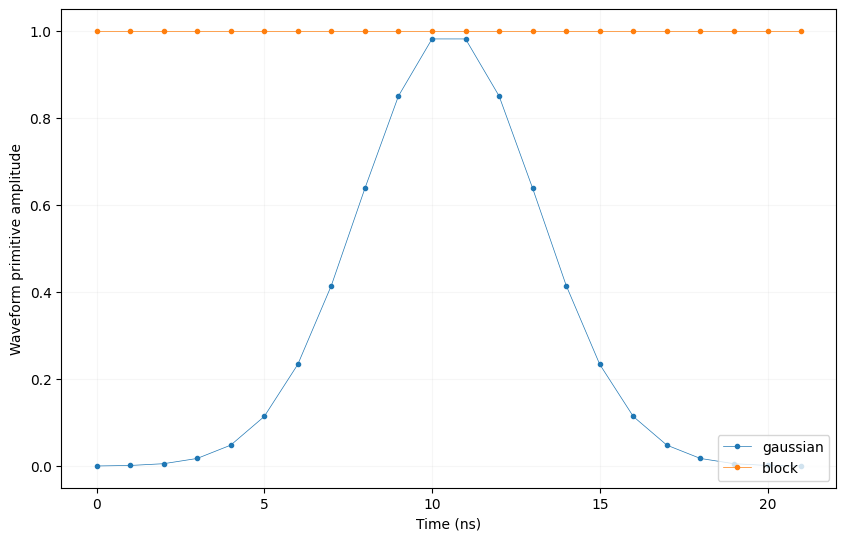

In [9]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

Create Q1ASM program
--------------------

Now that we have the waveforms for the sequence, we need a Q1ASM program that sequences the waveforms as previously described. The Q1ASM program can address the memory in the sequences waveforms and acquisitions to construct a program for playback. View [Q1 Programming](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#instructions) for a break down of available instructions in the Q1ASM language. 

In [10]:
# Sequence program.
seq_prog = """
       move      100,R0   #Loop iterator.
       move      20,R1    #Initial wait period in ns.
       wait_sync 4        #Wait for sequencers to synchronize and then wait another 4 ns.

loop:  set_mrk   1        #Set marker output 1.
       play      0,1,4    #Play a gaussian and a block on output path 0 and 1 respectively and wait 4 ns.
       set_mrk   0        #Reset marker output 1.
       upd_param 18       #Update parameters and wait the remaining 18 ns of the waveforms.

       wait      R1       #Wait period.

       play      1,0,22   #Play a block and a gaussian on output path 0 and 1 respectively and wait 22 ns.
       wait      1000     #Wait a 1us in between iterations.
       add       R1,20,R1 #Increase wait period by 20 ns.
       loop      R0,@loop #Subtract one from loop iterator.

       stop               #Stop the sequence after the last iteration.
"""

Prepare and Upload sequence
---------------------------

Now that we have the waveforms and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [11]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [13]:
# Upload sequence.
module.sequencer0.sequence("sequence.json")
module.sequencer1.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers in the instrument to use the `wait_sync` instruction
at the start of the Q1ASM program to synchronize.

In [14]:
# Configure the sequencers to synchronize.
module.sequencer0.sync_en(True)
module.sequencer1.sync_en(True)

# Map sequencers to specific outputs (but first disable all sequencer connections).
module.disconnect_outputs()

# If it is a QRM, we only map sequencer 0 to the outputs.
module.sequencer0.connect_sequencer("out0")
if module.is_qcm_type:
    module.sequencer1.connect_sequencer("out2_3")

Now let's start the sequence. If you want to observe the sequence, this is the time to connect an oscilloscope to marker output 1 and one or more
of the four outputs. Configure the oscilloscope to trigger on the marker output 1.

In [15]:
# Arm and start both sequencers.
module.arm_sequencer(0)
module.arm_sequencer(1)
module.start_sequencer()

# Print status of both sequencers.
print(module.get_sequencer_state(0))
print(module.get_sequencer_state(1))

Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: NONE


Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [16]:
# Stop both sequencers.
module.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(module.get_sequencer_state(0))
print(module.get_sequencer_state(1))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

Status: STOPPED, Flags: FORCED_STOP
Status: STOPPED, Flags: FORCED_STOP

Status: OKAY, Flags: NONE, Slot flags: NONE
